<a href="https://colab.research.google.com/github/jah1994/Image-Threshing-w.PyTorch/blob/master/OMFBD_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

In [163]:
# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
 process = psutil.Process(os.getpid())
 print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
 print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 11.1 GB  | Proc size: 2.6 GB
GPU RAM Free: 14321MB | Used: 1959MB | Util  12% | Total 16280MB


In [0]:
# make sure to enable GPU acceleration!
device = 'cuda'

In [168]:
import torch
import numpy as np
from astropy.io.fits import getdata
import matplotlib.pyplot as plt
from scipy.signal import convolve2d as conv
import os
from astropy.stats import mad_std
from matplotlib.colors import LogNorm
import time
from astropy.io import fits

#crop = 10
ks = 39
pw = 19

def convert_to_tensor(data):
    data = data.astype(np.float32)
    data = np.array([[data]])
    tensor = torch.from_numpy(data)
    return tensor

def infer_psf(init_psf, init_sky, prior_scene, data, steps, lam):
    
    # sky subtract (initial only?) scene
    #prior_scene = prior_scene - np.median(prior_scene)
    '''
    # convolve scene with kernel (as not to violate sampling theorem)
    kernel = np.exp(-0.5 * (np.arange(-2, 3)[:, None] ** 2
           + np.arange(-2, 3)[None, :] ** 2))
    kernel /= np.sum(kernel)
    
    prior_scene = conv(prior_scene, kernel, mode='same')
    '''
    '''
    prior_scene = np.pad(prior_scene, pad_width=pw, mode='constant', constant_values=0)
    prior_scene, data = convert_to_tensor(prior_scene), convert_to_tensor(data)

    # Move data to GPU
    prior_scene = prior_scene.to(device)
    data = data.to(device)
    '''

    model = torch.nn.Sequential(
        torch.nn.Conv2d(in_channels=1,
                        out_channels=1,
                        kernel_size=ks,
                        padding = pw,
                        padding_mode = 'zeros',
                        bias=True
    )
    )
    
    #model[0].weight = torch.nn.Parameter(1e-3* torch.ones(model[0].weight.shape, requires_grad=True))
    model[0].weight = init_psf
    model[0].bias = init_sky
    # Move model to GPU
    model = model.to(device)


    
    #print(model[0].bias)
    #loss_fn = torch.nn.MSELoss(reduction='sum')

    class chi_squared_loss(torch.nn.Module):
        
        def forward(model, targ, w, scale):
            #print('NM min, max', torch.min(NM), torch.max(NM))
            #print(NM)
            totloss = torch.sum((targ - model)**2)
            ## add L2 regularisation ##
            regtotloss = totloss + lam*scale*torch.abs(torch.sum(torch.pow(w, 2)))
            return regtotloss

    
    # Practical scale for L2 regularization
    scale = torch.sum(torch.pow(prior_scene, 2))

    losses_psf = []
    i_s = []

    # keep track of parameters to check convergene
    psf = []
    b = []
    
    # NNLS optimisation w. LBFGS
    #learning_rate = 1
    #optimizer = torch.optim.LBFGS(model.parameters(), lr=learning_rate)
    
    #NNLS optimisation w. Adam
    #learning_rate = 1e-3
    #optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    optimizer = torch.optim.Adam([
            {'params': model[0].weight, 'lr': 1e-3},
            {'params': model[0].bias, 'lr': 10} 
        ])
   
    for i in range(steps):

        #print(i)
        
        y_pred = model(prior_scene)
        #loss = loss_fn(y_pred, data)
        loss = chi_squared_loss.forward(y_pred, data, model[0].weight, scale)
        #print(loss)
        #if i % 100 == 99:
        #    print(i, loss.item())
        losses_psf.append(loss)
        i_s.append(i)
        optimizer.zero_grad()
        #print('Loss.backward')
        loss.backward(retain_graph=True)
        optimizer.step()
        #print('End optimizer step')
        psf.append(torch.sum(model[0].weight))
        b.append(torch.abs(torch.sum(model[0].bias)))
        # enforce non-negativity constraint on PSF
        #with torch.no_grad():
        #    model[0].weight.clamp_(min=0)
    
        # Heuristic convergence condition
        if i>100 and (1 - abs(losses_psf[-1]/losses_psf[-2])) < 1e-5:
            break
        #if t>100 and (1 - abs(psf[-1]/psf[-2])) < 1e-4 and (1 - abs(b[-1]/b[-2])) < 1e-4:
        #    break
    '''
    plt.plot(i_s, np.log(losses_psf))
    plt.xlabel('Iterations')
    plt.ylabel('log_10(loss)')
    plt.title('log loss vs iterations')
    plt.show()

    plt.plot(i_s, np.log(psf))
    plt.xlabel('Iterations')
    plt.ylabel('log_10(psf)')
    plt.title('log_10(psf)vs iterations')
    plt.show()

    plt.plot(i_s, np.log(b))
    plt.xlabel('Iterations')
    plt.ylabel('log_10(b)')
    plt.title('log b vs iterations')
    plt.show()
    '''
    inferred_psf = model[0].weight
    sky = model[0].bias
    #sky = sky.cpu()
    #sky = sky[0].detach().numpy()
    #print('sky:', torch.sum(sky))
    #print('psf_sum', torch.sum(inferred_psf[0][0]))
    return inferred_psf, sky
        
#def update_scene(scene_loss, prior_scene, data, current_psf, sky, min_s, alpha, beta, N, scene_smooth):
    
def thresh(s0, images):

    model2 = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,
                    out_channels=1,
                    kernel_size=ks,
                    padding = pw,
                    padding_mode = 'zeros',
                    bias=False)
    )
    '''
     ### Prepare kernel for light deconvolution
    kernel4lightdecon = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels=1,
                    out_channels=1,
                    kernel_size=15,
                    padding = 7,
                    padding_mode = 'zeros')
                    
    )
    # convolve scene with kernel (as not to violate sampling theorem)
    kernel = np.exp(-0.5 * (np.arange(-7, 8)[:, None] ** 2
            + np.arange(-7, 8)[None, :] ** 2))
    kernel /= np.sum(kernel)

    kernel = convert_to_tensor(kernel)
    # Equate kernel with learned psf
    kernel4lightdecon[0].weight = torch.nn.Parameter(kernel, requires_grad=False)

    # Move model to GPU
    kernel4lightdecon = kernel4lightdecon.to(device)
    '''
    #scene_smooth = 10
    class chi_squared_loss2(torch.nn.Module):
        
        def forward(model2, targ2, w2, eta):
            #print('NM min, max', torch.min(NM), torch.max(NM))
            #print(NM)
            totloss2 = torch.sum((targ2 - model2)**2)
            ## add L2 regularisation ##
            regtotloss2 = totloss2 + eta*torch.abs(torch.sum(torch.pow(w2, 2)))
            #regtotloss2 = totloss2 + eta*torch.abs(torch.sum(w2))
            #regtotloss2 = totloss2 + eta*(torch.abs(torch.sum(w2))/torch.abs(torch.sum(torch.pow(w2, 2))))
            return regtotloss2
    
    #learning_rate = 1e-3
    # Strength of L2 regularisation
    lam = 0
    #optimizer2 = torch.optim.Adam([prior_scene.requires_grad_()], lr=learning_rate, weight_decay=lam)
    #learning_rate = alpha / (beta + N)
    #learning_rate = alpha / (beta)
    #learning_rate = 10
    
    # TLI scene i.e. coaddition of these shifted frames
    tli_scene = s0

    #s0 = conv(s0, kernel[0][0], mode='same')
    s0 = convert_to_tensor(s0)
    s0 = s0.to(device)
    alpha, beta = 2, 1

    #s0 = kernel4lightdecon(s0)
    optimizer2 = torch.optim.SGD([s0.requires_grad_()], lr=2, weight_decay=0.) #0.01

    #optimizer2 = torch.optim.SGD([s0.requires_grad_()], lr=2, weight_decay=0.) #0.01
    #optimizer2 = torch.optim.Adam([s0.requires_grad_()], lr=1, weight_decay=0.1)
    #scale2 = torch.sum(torch.pow(s0, 2))
    #scale = 1
    #scene_smooth = 0
    start, end = 0, 1200
    for t in range(start, end):
        
        #print('Threshing frame %d of %d' % (t, end))
        data_imag = getdata(images[t+1], 0, header=True)[0][crop:512-crop, crop:512-crop]
        

        min_s = 0

        # sky subtract each data image
        data_imag -= np.median(data_imag)

        # build TLI scene for comparison
        tli_scene += data_imag

        # Apply some serious Hacks! #
        #s[np.where(s < 0)] = 0.
        data_imag[np.where(data_imag < 0)] = 0.
        
        # convert numpy arrays to tensors
        #s, data_imag = convert_to_tensor(s), convert_to_tensor(data_imag)
        data_imag = convert_to_tensor(data_imag)


        data_imag = data_imag.to(device) 


        ## convolve scene with lightdecon kernel
        #s0 = kernel4lightdecon(s0)
        #data_imag = kernel4lightdecon(data_imag)

        if t == 0:
            shape = (1, 1, ks, ks)
            init_psf = torch.nn.Parameter(torch.tensor(1e-3 * np.random.normal(size=shape), dtype=torch.float32))
            init_sky = torch.nn.Parameter(torch.tensor(1e-3*np.random.normal(size=1), dtype=torch.float32))
            print(init_sky.size())
        else:
            init_psf = inferred_psf
            init_sky = sky

        time_to_psf = time.time()
        inferred_psf, sky = infer_psf(init_psf, init_sky, s0, data_imag, 10000, lam=1)
        #print('Inferred psf in %f seconds' % (time.time()-time_to_psf))
        # subtract residual 'sky' from data image
        data_imag -= sky
        #print(type(s), type(data_imag), type(inferred_psf), type(sky))
        #print(s0.is_cuda, data_imag.is_cuda, inferred_psf.is_cuda, sky.is_cuda)
        #print('PSF sum:', torch.sum(inferred_psf))
        #print('Sky:', torch.sum(sky))
        #print(s0.size(), data_imag.size())


        # Equate kernel with learned psf
        # 'Turn off' bias for this pass as 'sky' subtracted above
        model2[0].weight = inferred_psf
        
        # Move model2 to GPU with this new psf
        model2 = model2.to(device)
        
        with torch.no_grad():
            #print(torch.median(s0[0][0]))
            s0[0][0] = s0[0][0] - torch.median(s0[0][0])
        
        #current_scene_estimate = s0
        time_to_scene_update = time.time()
        y_pred_scene = model2(s0)

        # Introduce something smoothing to suppress ringing
        # in the deconvolved scene
        eta = 0.1
        loss2 = chi_squared_loss2.forward(y_pred_scene, data_imag, s0.requires_grad_(), eta)
        scene_loss.append(loss2)
        iterations.append(t)
        #print(loss2)
        #if t % 100 == 99:
        #    print(t, loss2.item())
        optimizer2.zero_grad()
        loss2.backward(retain_graph=True)
        optimizer2.step()
        #print('Finished scene update in %f seconds' % (time.time()- time_to_scene_update))
        # non-negativity constraint on scene?
        #with torch.no_grad():
        #  s0.clamp_(min=0.)
        #  for param in model2.parameters():
        #      param.clamp_(min=0.)

        for param_group in optimizer2.param_groups:
            param_group['lr'] = alpha / (beta + t)
        
        if t % 200 == 0:
            print('Threshed frame %d of %d' % (t, end))

            to_plot_s = s0[0][0].cpu().detach().numpy()
            
            hdu = fits.PrimaryHDU(to_plot_s)
            hdul = fits.HDUList([hdu])
            hdul.writeto(os.path.join(path, 's_full_singleimageasinit_L2_' + str(eta) + '_' + str(t) + '_' + str(alpha) + '.fits'), overwrite=True)

            hdu = fits.PrimaryHDU(tli_scene)
            hdul = fits.HDUList([hdu])
            hdul.writeto(os.path.join(path, 'tli_full_' + str(t) + '.fits'), overwrite=True)
            
            to_plot_psf = inferred_psf[0][0].cpu().detach().numpy()
            #to_plot_kernel = kernel4lightdecon[0].weight[0][0].cpu().detach().numpy()
            plt.figure()
            f, axarr = plt.subplots(1,3)
            #f.set_figheight(15)
            #f.set_figwidth(15)
            axarr[0].imshow(to_plot_s, norm=LogNorm())
            axarr[1].imshow(to_plot_psf)
            axarr[2].imshow(tli_scene, norm=LogNorm())
            plt.show()
        

    return s0
'''
if t % 10 == 0:

try:
  inf_psf = inferred_psf[0][0].cpu().detach().numpy()
except AttributeError:
  pass

try:
  s0 = s0[0][0].cpu().detach().numpy()
except AttributeError:
  pass
GB

#inf_psf = inferred_psf
plt.figure(figsize=(10,10))
f, axarr = plt.subplots(1,2)
f.set_figheight(15)
f.set_figwidth(15)
axarr[0].imshow(inf_psf)
axarr[1].imshow(s0, norm=LogNorm())
#axarr[2].imshow(s-s0,norm=LogNorm())
plt.show()

# move s0 back to device
s0 = convert_to_tensor(s0)
s0 = s0.to(device)

'''
'''
current_scene = prior_scene[0][0].cpu().detach().numpy()
print('Min in scene:', np.min(current_scene))
print('Max in scene:', np.max(current_scene))
print('Scene shape:', current_scene.shape)
#current_scene = current_scene[pw:current_scene.shape[0]-(+pw), pw:current_scene.shape[1] - (+pw)]
#print(current_scene.shape)    
return current_scene
'''


"\ncurrent_scene = prior_scene[0][0].cpu().detach().numpy()\nprint('Min in scene:', np.min(current_scene))\nprint('Max in scene:', np.max(current_scene))\nprint('Scene shape:', current_scene.shape)\n#current_scene = current_scene[pw:current_scene.shape[0]-(+pw), pw:current_scene.shape[1] - (+pw)]\n#print(current_scene.shape)    \nreturn current_scene\n"

torch.Size([1])
Threshed frame 0 of 1200


<Figure size 432x288 with 0 Axes>

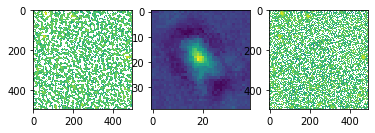

Threshed frame 200 of 1200


<Figure size 432x288 with 0 Axes>

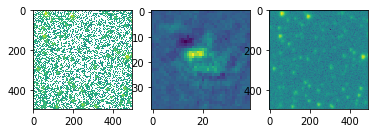

Threshed frame 400 of 1200


<Figure size 432x288 with 0 Axes>

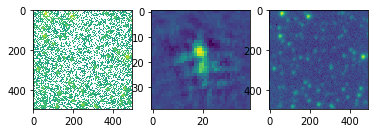

In [0]:

########################## Load image sequence ######################
crop = 10

#path = '/media/james/Seagate_Expansion_Drive#2/makesyntheticscenes/'
#path = '/home/james/Documents/LI_Reduction_test/OGLE_spools_test/'

path = '/content/drive/My Drive/OGLE_spools_test_2mins'

images = []

for root, dirs, files in os.walk(path):
    for file in files:
        if '.fits' in file and 'Llr' not in file and 'OGLE' in file:
            images.append(os.path.join(path, file))
        
#print(images)        
# initial guess at scene

#s0 = getdata(os.path.join(path, 'initial_00000.fits'), 0, header=True)[0][0:crop, 0:crop]
#s0 = getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'), 0, header=True)[0]
#stacked_image = np.zeros((512, 512))
#for l in range(0,1): # top l quality cuts
#    stacked_image = stacked_image + s0[l]

#s0 = stacked_image[crop:512-crop, crop:512-crop]   

#plt.imshow(s0)
#plt.show()
'''
cube = getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'), 0, header=True)[0]
images = []
for l in range(1, 10):
    images.append(cube[l])
'''
#s0 = images[0]

#s0 = getdata('tli_top1.fits', 0, header=True)[0][0:crop, 0:crop]  


# keep track of overall loss for the estimate of the scene for every input image
scene_loss = []
iterations = []

s0 = getdata(images[0], 0, header=True)[0][crop:512-crop, crop:512-crop]
s0 -= np.median(s0)
s0[np.where(s0 < 0)] = 0.

s = thresh(s0, images)

In [0]:
from astropy.io import fits
s = s[0][0].cpu().detach().numpy()
hdu = fits.PrimaryHDU(s)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(path, 's_tinierkerneltimes4_400scsimages_tliinit_psfreg01+psfnonneg.fits'))

In [0]:
import os
from astropy.stats import mad_std
from matplotlib.colors import LogNorm

crop = 100

#path = '/media/james/Seagate_Expansion_Drive#2/makesyntheticscenes/'
#path = '/home/james/Documents/LI_Reduction_test/OGLE_spools_test/'

path = '/content/drive/My Drive/OGLE_spools_test'

images = []

for root, dirs, files in os.walk(path):
    for file in files:
        if '.fits' in file and 'Llr' not in file:
            images.append(os.path.join(path, file))
        
#print(images)        
# initial guess at scene

#s0 = getdata(os.path.join(path, 'initial_00000.fits'), 0, header=True)[0][0:crop, 0:crop]
#s0 = NRof 4.6dB.getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'), 0, header=True)[0]
#stacked_image = np.zeros((512, 512))
#for l in range(0,1): # top l quality cuts
#    stacked_image = stacked_image + s0[l]
#s0 = stacked_image[crop:512-crop, crop:512-crop]   

#plt.imshow(s0)
#plt.show()
'''
cube = getdata(os.path.join(path, 'OGLE-III-BLG101_Llr_2019-07-18_00008.fits'), 0, header=True)[0]
images = []
for l in range(1, 10):
    images.append(cube[l])
'''
#s0 = images[0]

#s0 = getdata('tli_top1.fits', 0, header=True)[0][0:crop, 0:crop]  


npasses = 0
# keep track of overall loss for the estimate of the scene for every input image
scene_loss = []
iterations = []

s0 = getdata(images[0], 0, header=True)[0][crop:512-crop, crop:512-crop]
#for image in images[1:]:
for image in images[1:]:

    #print(image)
    #data_imag = image
    print('Pass;', npasses)
    data_imag = getdata(image, 0, header=True)[0][crop:512-crop, crop:512-crop]
      
    print(s0.shape, data_imag.shape)
    if npasses == 0:
        s = s0
        s -= np.median(s)
        #min_s = np.min(s)
        min_s = 0

    # noise variance for smoothing
    #noise_std = mad_std(s)
    #noise_variance = noise_std**2
    #print('Noise variance in scene', noise_variance)
    
    # Display initialisation and input image
    #plt.figure(figsize=(5,5))
    #f, axarr = plt.subplots(1,2)
    #f.set_figheight(15)
    #f.set_figwidth(15)
    #axarr[0].imshow(data_imag)
    #axarr[1].imshow(s)
    #plt.show()
    ## 'sky' subract scene and data_imag
    #s -= np.median(s)
    
    data_imag -= np.median(data_imag)

    # Hack! #
    s[np.where(s < 0)] = 0.
    data_imag[np.where(data_imag < 0)] = 0.

    #if npasses!=0:
    #    s = s[crop:512-crop, crop:512-crop]
    #s = np.pad(s, pad_width=pw, mode='constant', constant_values=0)
    s, data_imag = convert_to_tensor(s), convert_to_tensor(data_imag)

    # Move data to GPU
    s = s.to(device)
    data_imag = data_imag.to(device) 
    
    inferred_psf, sky = infer_psf(s, data_imag, 1000, lam=3)

    # subtract residual 'sky' from data image
    data_imag -= sky
    #print(type(s), type(data_imag), type(inferred_psf), type(sky))
    print(s.is_cuda, data_imag.is_cuda, inferred_psf.is_cuda, sky.is_cuda)
    print('PSF sum:', torch.sum(inferred_psf))
    print('Sky:', torch.sum(sky))
    print(s.size(), data_imag.size())
    s = update_scene(scene_loss, s, data_imag, inferred_psf, sky, min_s, alpha=200, beta=1, N=npasses, scene_smooth=1e-2)
    #print(s.shape(), data_imag.size())

    iterations.append(npasses)
    plt.plot(iterations, scene_loss)
    plt.show()
    
    if npasses % 10 == 0:
    
      try:
          inf_psf = inferred_psf[0][0].cpu().detach().numpy()
      except AttributeError:
          pass

      try:
          s = s[0][0].cpu().detach().numpy()
      except AttributeError:
          pass
      
      #inf_psf = inferred_psf
      plt.figure(figsize=(10,10))
      f, axarr = plt.subplots(1,3)
      f.set_figheight(15)
      f.set_figwidth(15)
      axarr[0].imshow(inf_psf)
      axarr[1].imshow(s, norm=LogNorm())
      axarr[2].imshow(s-s0,norm=LogNorm())
      plt.show()
      
    npasses = npasses + 1


IndexError: ignored

In [0]:
from astropy.io import fits
s = s[0][0].cpu().detach().numpy()
hdu = fits.PrimaryHDU(s)
hdul = fits.HDUList([hdu])
hdul.writeto(os.path.join(path, 's_lralpha10beta1_scenesmooth1eminus3.fits'))

AttributeError: ignored